# Lab Assignment 1

Student name: [fill in]

## Notebook version

This notebook includes all the codes in the codebase of lab assignment 1. Completing and submitting this script is equivalent to submitting the codebase. Please note that your submitted script should include errorless cell outputs that contain necessary information that proves you have successfully run the notebook in your own directory.

You can choose to (1) run this notebook locally on your end or (2) run this notebook on colab. For the former, you will need to download the dataset to your device that resembles the instructions for the codebase. For the latter, **you will need to upload the dataset to your Google Drive** account, and connect your colab notebook to your Google Drive. Then, go to "File->Save a copy in Drive" to create a copy you can edit.


#### Colab (if applicable)

If you are running this script on colab, uncomment and run the cell below:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Note that the Google Drive directory has the root `/content/drive/`. For instance, my directory to the dataset is `'/content/drive/My Drive/Courses/CSCI 5922/CSCI 5922 SP25/Demo/MNIST/'`.

### mnist.py

In [ ]:
#Original source: https://www.kaggle.com/code/hojjatk/read-mnist-dataset
#It has been modified for ease of use w/ pytorch

#You do NOT need to modify ANY code in this file!

import numpy as np
import struct
from array import array
import torch

class MnistDataloader(object):
    def __init__(self, training_images_filepath,training_labels_filepath,
                 test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath

    def read_images_labels(self, images_filepath, labels_filepath):
        n = 60000 if "train" in images_filepath else 10000
        labels = torch.zeros((n, 10))
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            l = torch.tensor(array("B", file.read())).unsqueeze(-1)
            l = torch.concatenate((torch.arange(0, n).unsqueeze(-1), l), dim = 1).type(torch.int32)
            labels[l[:,0], l[:,1]] = 1

        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())
        images = torch.zeros((n, 28**2))
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            #img = img.reshape(28, 28)
            images[i, :] = torch.tensor(img)

        return images, labels

    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return (x_train, y_train),(x_test, y_test)

### activations.py

In [ ]:
import torch

class ReLU():
    #Complete this class
    def forward(x: torch.tensor) -> torch.tensor:
        #implement ReLU(x) here
        return torch.maximum(x, torch.tensor(0.0))

    def backward(delta: torch.tensor, x: torch.tensor) -> torch.tensor:
        #implement delta * ReLU'(x) here
        grad = (x > 0).float()  # Derivative is 1 for x > 0, else 0
        return delta * grad

class LeakyReLU():
    #Complete this class
     def forward(x: torch.tensor) -> torch.tensor:
        #implement LeakyReLU(x) here
        return torch.maximum(x, 0.1 * x)

     def backward(delta: torch.tensor, x: torch.tensor) -> torch.tensor:
        #implement delta * LeakyReLU'(x) here
        grad = torch.where(x > 0, 1.0, 0.1 )
        return delta * grad

### framework.py

Test Accuracy (Final): 85.47491455078125
tensor([21.2200, 36.8000, 48.8700, 56.9600, 62.5700, 67.1600, 70.7000, 73.3800,
        75.0900, 76.8700, 77.7300, 79.2000, 79.7600, 80.6700, 81.3400, 81.8400,
        82.5600, 82.9200, 83.4400, 83.8500, 84.1800, 84.4300, 84.8500, 85.2500,
        85.4700])


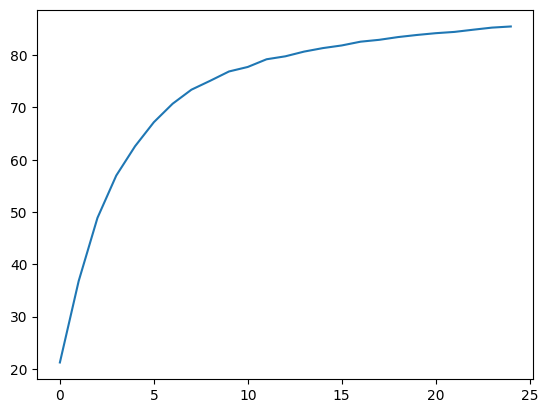

In [ ]:
import torch
import numpy as np
import tqdm
import matplotlib.pyplot as plt

class MLP:
    '''
    This class should implement a generic MLP learning framework. The core structure of the program has been provided for you.
    But, you need to complete the following functions:
    1: initialize()
    2: forward(), including activations
    3: backward(), including activations
    4: TrainMLP()
    '''
    def __init__(self, layer_sizes: list[int]):
        #Storage for model parameters
        self.layer_sizes: list[int] = layer_sizes
        self.num_layers = len(layer_sizes) - 1
        self.weights: list[torch.tensor] = []
        self.biases: list[torch.tensor] = []

        #Temporary data
        self.features: list[torch.tensor] = []

        #hyper-parameters w/ default values
        self.learning_rate: float = 1
        self.batch_size: int = 1
        self.activation_function: callable[[torch.tensor], torch.tensor] = ReLU

    def set_hp(self, lr: float, bs: int, activation: object) -> None:
        self.learning_rate = lr
        self.batch_size = bs
        self.activation_function = activation

        return

    def initialize(self) -> None:
        #Complete this function

        '''
        initialize all biases to zero, and all weights with random sampling from a unifrom distribution.
        This uniform distribution should have range +/- sqrt(6 / (d_in + d_out))
        '''
        self.weights = []
        self.biases = []
        torch.manual_seed(0)
        for i in range(self.num_layers):
            inputDimension = self.layer_sizes[i]
            outputDimension = self.layer_sizes[i + 1]

             # Calculate the bound for the uniform distribution
            bound = np.sqrt(6 / (inputDimension + outputDimension))

            #Initialize weight matrix
            Weight = torch.empty(inputDimension, outputDimension).uniform_(-bound, bound)

            #Initialize bias  with 0
            bias = torch.zeros(outputDimension)
            self.weights.append(Weight)
            self.biases.append(bias)
        return

    def forward(self, x: torch.tensor) -> torch.tensor:
        #Complete this function

        '''
        This function should loop over all layers, forward propagating the input via:
        x_i+1 = f(x_iW + b)
        Remember to STORE THE INTERMEDIATE FEATURES!
        '''
        self.features = [x]      # store input
        self.z_values = []       # clear previous z-values if any

        acti = x
        # Hidden layers: use activation function
        for i in range(self.num_layers - 1):
            z = acti @ self.weights[i] + self.biases[i]
            self.z_values.append(z)
            acti = self.activation_function.forward(z)
            self.features.append(acti)

        # Final layer: no activation function
        z = acti @ self.weights[-1] + self.biases[-1]
        self.z_values.append(z)
        self.features.append(z)
        return z

    def backward(self, delta: torch.tensor) -> None:
        #Complete this function

        '''
        This function should backpropagate the provided delta through the entire MLP, and update the weights according to the hyper-parameters
        stored in the class variables.
        '''
        i = self.num_layers - 1
        a_prev = self.features[i]  # input to final layer
        d_w = a_prev.t() @ delta
        d_b = torch.sum(delta, dim=0)

        #weights and biases using gradient descent
        self.weights[i] -= self.learning_rate * d_w
        self.biases[i] -= self.learning_rate * d_b

        # Backpropagation
        for i in reversed(range(self.num_layers - 1)):
            #multiply by the weight matrix to next layer
            delta = (delta @ self.weights[i + 1].t())

            # derivative of activation function to delta
            delta = self.activation_function.backward(delta, self.z_values[i])

            a_prev = self.features[i]
            d_w = a_prev.t() @ delta
            d_b = torch.sum(delta, dim=0)


            self.weights[i] -= self.learning_rate * d_w
            self.biases[i] -= self.learning_rate * d_b
        return


def TrainMLP(model: MLP, x_train: torch.tensor, y_train: torch.tensor) -> MLP:
    #Complete this function

    '''
    This function should train the MLP for 1 epoch, using the provided data and forward/backward propagating as necessary.
    '''

    #set up a random sampling of the data
    bs = model.batch_size
    N = x_train.shape[0]
    rng = np.random.default_rng()
    idx = rng.permutation(N)

    total_loss = 0.0

    #for i in tqdm.tqdm(range(N // bs)):
    for i in range(N // bs):
        # Get mini-batch.
        x = x_train[idx[i * bs:(i + 1) * bs], ...]
        y = y_train[idx[i * bs:(i + 1) * bs], ...]

        # Forward propagation.
        logits = model.forward(x)

        # Compute softmax probabilities.
        # Note: using exponentiation and normalization.
        p = torch.exp(logits)
        p /= torch.sum(p, dim=1, keepdim=True)

        # Compute cross-entropy loss.
        # Adding a small epsilon to avoid log(0)
        #eps = 1e-8
        loss = -torch.sum(y * torch.log(p))
        total_loss += loss

        # Compute the gradient at the output.
        # For softmax cross-entropy, the gradient is: (p - y)
        delta = p - y

        # Backward propagation.
        model.backward(delta)

    #print("Train Loss:", total_loss / (N))
    return model

def TestMLP(model: MLP, x_test: torch.tensor, y_test: torch.tensor) -> tuple[float, float]:
    bs = model.batch_size
    N = x_test.shape[0]

    rng = np.random.default_rng()
    idx = rng.permutation(N)

    L = 0
    A = 0

    #for i in tqdm.tqdm(range(N // bs)):
    for i in range(N // bs):
        x = x_test[idx[i * bs:(i + 1) * bs], ...]
        y = y_test[idx[i * bs:(i + 1) * bs], ...]

        y_hat = model.forward(x)
        p = torch.exp(y_hat)
        p /= torch.sum(p, dim = 1, keepdim = True)

        l = -1 * torch.sum(y * torch.log(p+1e-6))
        L += l

        A += torch.sum(torch.where(torch.argmax(p, dim = 1) == torch.argmax(y, dim = 1), 1, 0))

    loss = L / ((N // bs) * bs)
    accuracy = 100 * A / ((N // bs) * bs)
    #print("Test Loss:", L / ((N // bs) * bs), "Test Accuracy: {:.2f}%".format(100 * A / ((N // bs) * bs)))
    return loss, accuracy

def normalize_mnist() -> tuple[torch.tensor, torch.tensor, torch.tensor, torch.tensor]:
    '''
    This function loads the MNIST dataset, then normalizes the "X" values to have zero mean, unit variance.
    '''

    #IMPORTANT!!!#
    #UPDATE THE PATH BELOW!#
    base_path = '/content/drive/MyDrive/MNIST/' #Update this to point to your downloaded MNIST files
    #^^^^^^^^#


    mnist = MnistDataloader(base_path + "train-images.idx3-ubyte", base_path + "train-labels.idx1-ubyte",
                            base_path + "t10k-images.idx3-ubyte", base_path + "t10k-labels.idx1-ubyte")
    (x_train, y_train), (x_test, y_test) = mnist.load_data()

    x_mean = torch.mean(x_train, dim = 0, keepdim = True)
    x_std = torch.std(x_train, dim = 0, keepdim = True)

    x_train -= x_mean
    x_train /= x_std
    x_train[x_train != x_train] = 0

    x_test -= x_mean
    x_test /= x_std
    x_test[x_test != x_test] = 0

    return x_train, y_train, x_test, y_test

def main():
    '''
    This is an example of how to use the framework when completed. You can build off of this code to design your experiments for part 2.
    '''

    x_train, y_train, x_test, y_test = normalize_mnist()

    # Example: MLP with one hidden layer of size 256.
    model =  MLP([784, 512, 10])
    model.initialize()
    model.set_hp(lr=1e-6, bs=512, activation=ReLU)

    E = 25  # number of epochs
    final_accuracy = 0
    test_accuracy = []
    for epoch in range(E):
        #print(f"\nEpoch {epoch+1}/{E}")
        TrainMLP(model, x_train, y_train)
        #TestMLP(model, x_test, y_test)
        loss, accuracy = TestMLP(model, x_test, y_test)
        test_accuracy.append(accuracy.item())

    print("Test Accuracy (Final):", test_accuracy[-1])

    plt.plot(test_accuracy)
    test_accuracy = torch.floor(torch.tensor(test_accuracy) * 100) / 100
    print(test_accuracy)

'''
    For the experiment, adjust the list [784,...,10] as desired to test other architectures.
    You are encouraged to play around with any of the following values if you so desire:
    E, lr, bs, activation
    '''
if __name__ == "__main__":
    main()

In [ ]:
#model = MLP([784, 256, 10]) Test Accuracy (Final): 84.5600357055664
model1 = [24.1600, 36.3100, 46.0000, 53.1500, 58.7700, 62.7100, 66.4700, 69.3600,
        71.2500, 73.1700, 74.7900, 76.2400, 77.6900, 78.5500, 79.3600, 80.0300,
        80.6200, 81.4700, 81.9900, 82.6400, 82.9900, 83.6000, 84.0000, 84.1700,
        84.5600]

#model = MLP([784, 512, 10])
model2 = [21.2500, 36.7500, 49.1100, 57.0100, 62.6500, 67.2400, 70.5600, 73.3400,
        74.9800, 76.7700, 77.8600, 79.0200, 79.6900, 80.8000, 81.1900, 81.8600,
        82.5800, 83.1100, 83.4700, 83.6700, 84.0500, 84.3900, 84.8000, 85.1700,
        85.3300]

#model = MLP([784, 512, 1025, 10])
model3 = [26.9800, 42.1600, 52.4900, 58.7900, 63.9600, 67.9900, 70.9600, 73.4100,
        75.3900, 77.0200, 78.3500, 79.2200, 80.1200, 81.0600, 81.6300, 82.0900,
        82.7700, 83.2600, 83.6500, 83.9000, 84.3500, 84.5000, 84.9400, 85.1300,
        85.3100]

#model = MLP([784, 256, 512, 1024, 10])
model4 = [16.8500, 27.2900, 36.2400, 44.6500, 50.2100, 55.1600, 58.5900, 61.4400,
        64.2600, 66.3900, 68.4700, 70.0000, 71.5900, 72.7600, 73.9900, 75.0300,
        75.9600, 76.7800, 77.4000, 78.0100, 78.5600, 78.9000, 79.4600, 79.8300,
        80.2500]

#model = MLP([784, 64, 64, 64, 10])
model5 =[13.2700, 16.0700, 19.1000, 21.7900, 24.4200, 26.8800, 29.6200, 31.8900,
        33.9900, 36.2100, 38.1100, 40.0400, 41.7300, 43.1900, 44.6800, 46.3700,
        47.9700, 49.6100, 51.4400, 52.7900, 54.5000, 55.8000, 56.9700, 58.5800,
        59.8600]





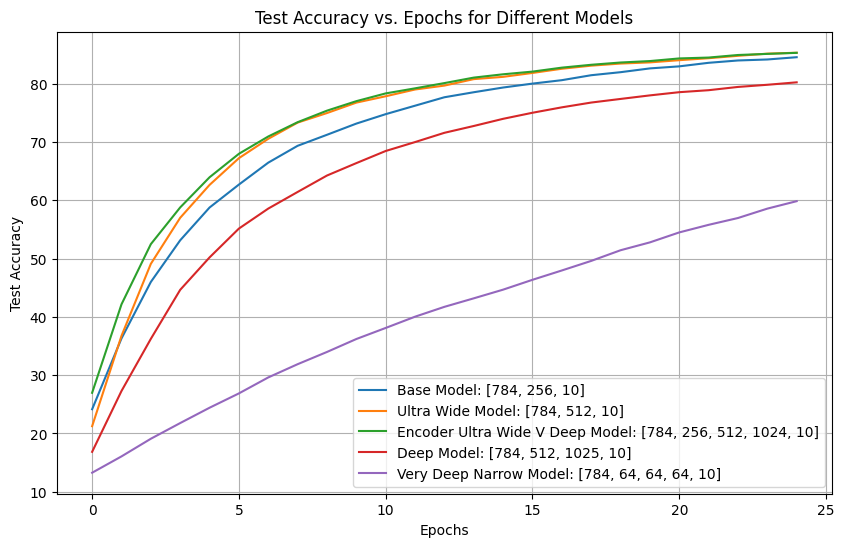

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(model1, label="Base Model: [784, 256, 10]")
plt.plot(model2, label="Ultra Wide Model: [784, 512, 10]")
plt.plot(model3, label="Encoder Ultra Wide V Deep Model: [784, 256, 512, 1024, 10]")
plt.plot(model4, label="Deep Model: [784, 512, 1025, 10]")
#plt.plot(model5, label="Deep Narrow Model: [784, 128, 128, 10]")
plt.plot(model5, label="Very Deep Narrow Model: [784, 64, 64, 64, 10]")

# Labels and legend

plt.xlabel("Epochs")
plt.ylabel("Test Accuracy")
plt.title("Test Accuracy vs. Epochs for Different Models")
plt.legend()
plt.grid(True)

# Show plot
plt.show()

In [ ]:
reLU = [21.3000, 36.7700, 48.9500, 57.0100, 62.7400, 67.2100, 70.5600, 73.3000,
        75.1800, 76.7600, 77.8100, 79.2100, 79.8700, 80.6100, 81.4200, 81.8500,
        82.5900, 82.9800, 83.3800, 83.6900, 84.1100, 84.3900, 84.8300, 85.1800,
        85.3600]
leakyRelu = [22.0000, 39.3600, 51.4200, 59.4200, 64.6400, 68.9000, 72.3000, 74.4300,
        76.1500, 77.5900, 78.7800, 79.6200, 80.5400, 81.2000, 81.8200, 82.6400,
        83.0700, 83.5400, 83.9200, 84.3200, 84.5800, 85.0600, 85.1800, 85.6000,
        85.8300]

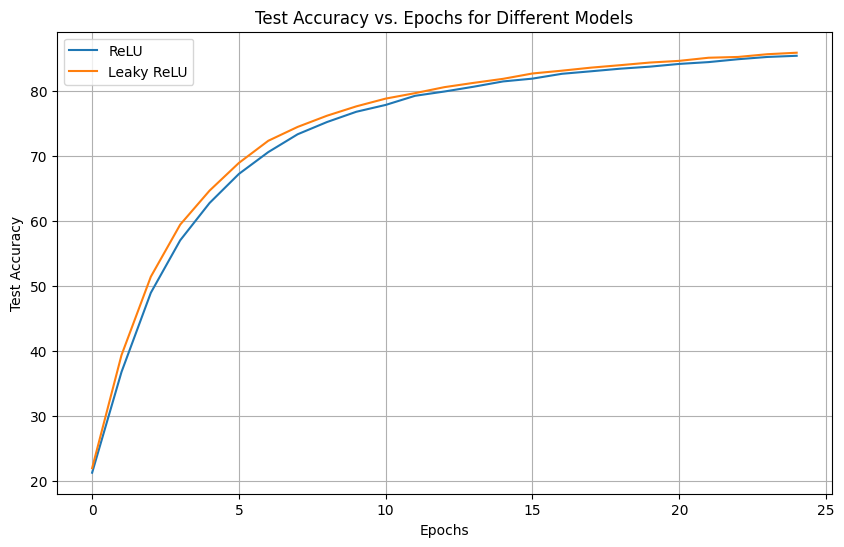

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(reLU, label="ReLU")
plt.plot(leakyRelu, label="Leaky ReLU")


# Labels and legend

plt.xlabel("Epochs")
plt.ylabel("Test Accuracy")
plt.title("Test Accuracy vs. Epochs for Different Models")
plt.legend()
plt.grid(True)

# Show plot
plt.show()

In [ ]:
learningRate4 = [91.0500, 92.6200, 93.5200, 93.9100, 94.4200, 94.9400, 95.0300, 95.3300,
        95.4600, 95.5700, 95.7100, 95.8900, 95.9700, 96.0400, 96.1900, 96.2900,
        96.3600, 96.4000, 96.3700, 96.4100, 96.4600, 96.5800, 96.5800, 96.5800,
        96.6300]

learningRate6 = [21.2200, 36.8000, 48.8700, 56.9600, 62.5700, 67.1600, 70.7000, 73.3800,
        75.0900, 76.8700, 77.7300, 79.2000, 79.7600, 80.6700, 81.3400, 81.8400,
        82.5600, 82.9200, 83.4400, 83.8500, 84.1800, 84.4300, 84.8500, 85.2500,
        85.4700]

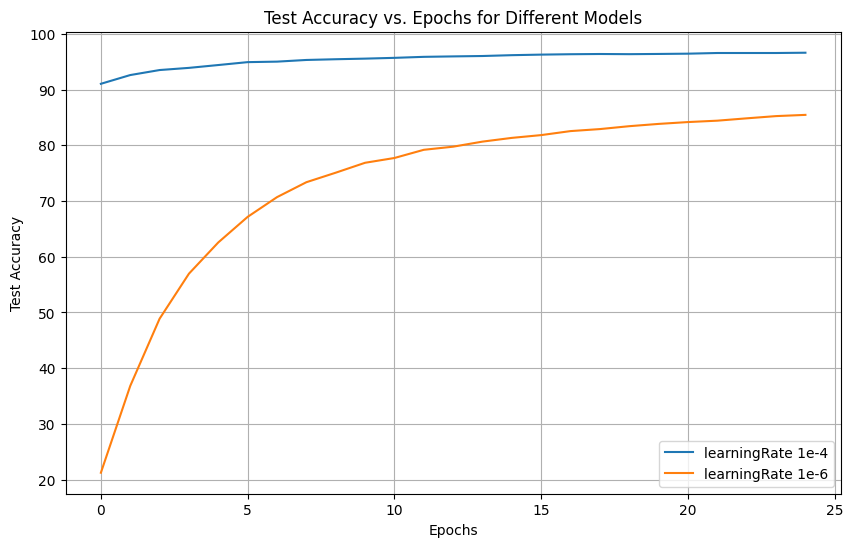

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(learningRate4, label="learningRate 1e-4")
plt.plot(learningRate6, label="learningRate 1e-6")


# Labels and legend

plt.xlabel("Epochs")
plt.ylabel("Test Accuracy")
plt.title("Test Accuracy vs. Epochs for Different Models")
plt.legend()
plt.grid(True)

# Show plot
plt.show()